# Testing Different SVMs on IRIS Data
<div class="alert alert-block alert-info">
<b>Content:</b> In this notebook, we use the IRIS Dataset (or rather a subset of it) to demonstrate different SVMs.
</div>


In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.svm import SVC 
import time 
from sklearn import metrics

## Loading the Dataset
* Iris data is part of a couple of libraries, among them Seaborn

In [35]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [36]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

The data has four features, thus we cannot visualize it directly. Therefore, we compare pairs of features in the pairplot.
We can observe, that among the three species, the members of setosa form an isolated cluster, whereas versicolor and virginica are not as clearly separable.

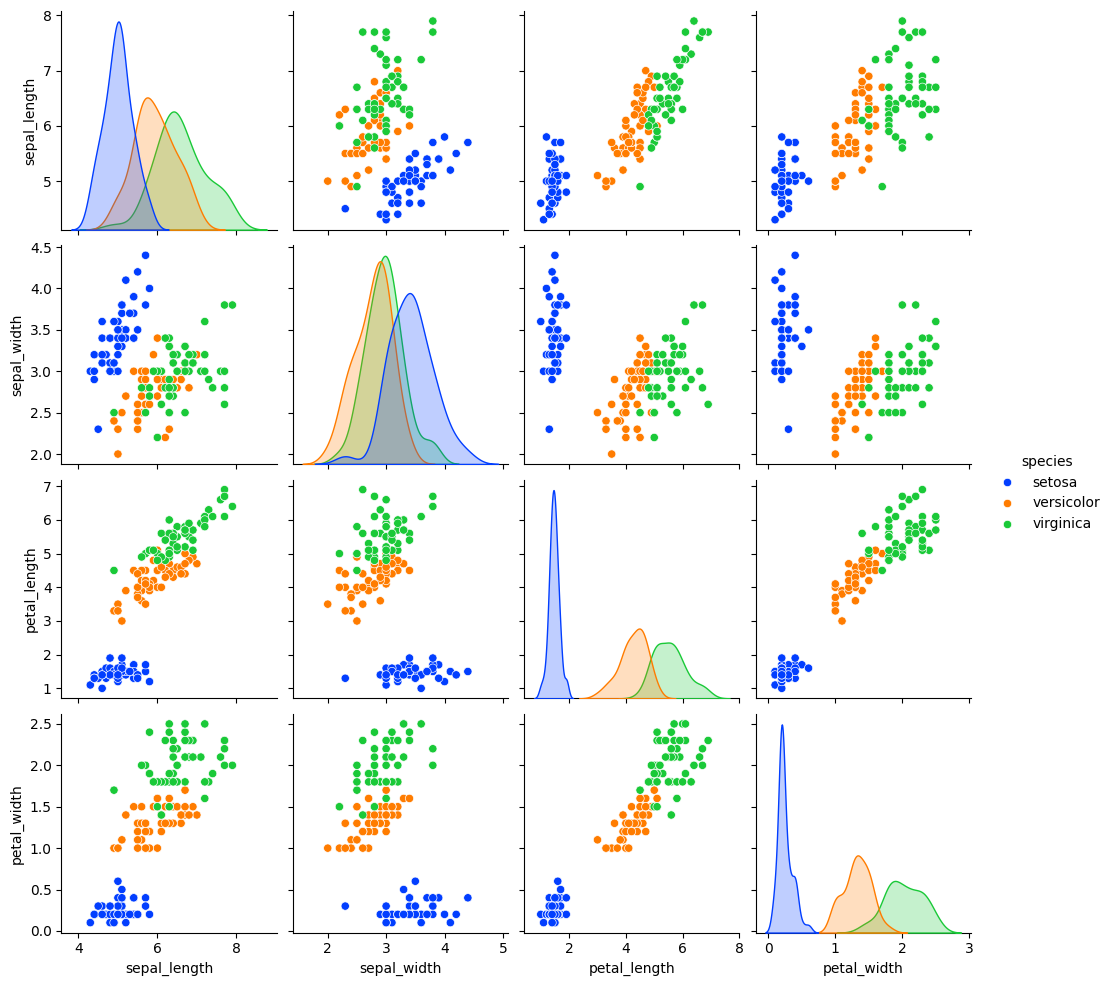

In [37]:
y = iris.species
X = iris.drop('species',axis=1)
sns.pairplot(iris, hue="species",palette="bright")

## SVM Experiment

### Data preprocessing
* For the sake of simplicity in this demo, we only consider a two-class problem: setosa vs. versicolor. The SVM implementation can cover multidimensional problems as well (tbd later during the term).
* Also, we want to be able to visualize the data and the resulting SVM directly. Therefore, we only use two features and drop the others.
* We replace the species by numerical values, as that is what the SVM can work with.
* Finally, we split the data into features X and classes y.

Let's start with a separable case (look at the pairplots!)

In [38]:
df=iris[(iris['species']!='virginica')]

df=df.drop(['sepal_length','sepal_width'], axis=1)

# used to automatically downcast, but will be removed in future versions (like here, casting to object)
pd.set_option('future.no_silent_downcasting', True)
df=df.replace('setosa', -1)
df=df.replace('versicolor', +1)
df["species"] = pd.to_numeric(df["species"])

X=df.iloc[:,0:2]
y=df['species']

df.head()

,petal_length,petal_width,species
0,1.4,0.2,-1
1,1.4,0.2,-1
2,1.3,0.2,-1
3,1.5,0.2,-1
4,1.4,0.2,-1


In [39]:
df.dtypes


petal_length    float64
petal_width     float64
species           int64
dtype: object

## Creating Visuals
To investigate SVMs and also to support communication of our results (e.g. in a company to co-workers, custormers, superiors, ...) we visualize our results

In [40]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['dodgerblue', 'darkorange'])

# Plot the dataset together with additional content and store under the given filename
# X the dataset
# y the labels
# content_func a function that is executed to plot specific content into the otherwise standardized diagram
def plot_svm(X, y, content_func):
    X_0=X.iloc[:, 0] # values in dim 0
    X_1=X.iloc[:, 1] # values in dim 1

    f = plt.figure(figsize=(15, 15))
    ax = plt.gca()
    scatter=ax.scatter(X_0, X_1, c=y, s=50, cmap=cmap, label=y)
    
    ax.set_aspect('equal', 'box') # otherwise our linear classifier will look warped
    ax.set_xlim(0,math.ceil(1.1*X_0.max()))
    ax.set_ylim(0,math.ceil(1.1*X_1.max()))  
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    
    content_func(ax)
    
    L=ax.legend(*scatter.legend_elements(),
                    bbox_to_anchor=(1,0.4), loc="center right", title="classes", ncol=1)
    L.get_texts()[1].set_text('+1') # special handling of +1 in the legend

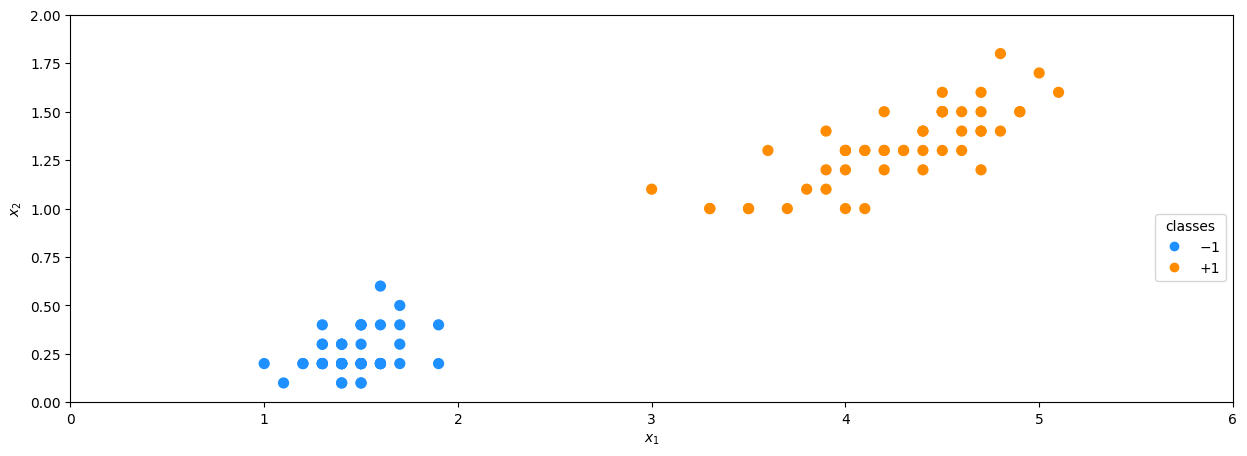

In [41]:
def no_content(ax):
    pass
plot_svm(X, y, no_content)

## Learning SVMs

In [42]:
# Describe the properities of an SVM
# clf the classifier
# X features
# y labels
# param_name the parameter we investigate (e.g. with different values)
# param the parameter value
def describe_svm(clf, X, y, param_name, param):
    clf.fit(X, y)
    sv=clf.support_vectors_
    y_pred=clf.predict(X)
    acc=round(metrics.accuracy_score(y, y_pred),5)
    print(f"{param_name}: ", param, "   svs: ", len(sv), "   train-acc: ", acc)

### Hard-Margin

We start with a linear SVM. There is no implementation for hard-margin SVMs. But we can punish digressions so hard, that the trade-off is biased towards margin rather than digression.

In [43]:
model = SVC(kernel='linear', C=1E2)
model.fit(X, y)
describe_svm(model, X, y, "C", 1E2)

C:  100.0    svs:  2    train-acc:  1.0


Let's investigate our model, what does the linear classifier look like?

In [44]:
w=model.coef_[0]
w_0=w[0]
w_1=w[1]
b=model.intercept_[0]

In [45]:
c_alpha=model.dual_coef_ # c_alpha[0,i] = c_i*alpha_i
sv=model.support_vectors_

print(np.round(w,8))
print(c_alpha[0,0]*sv[0] + c_alpha[0,1]*sv[1]) 
# as expected, w is a linear combination of support vectors
# (their actually computed values are different in the 16th digit)

[1.29411744 0.82352928]
[1.29411744 0.82352928]


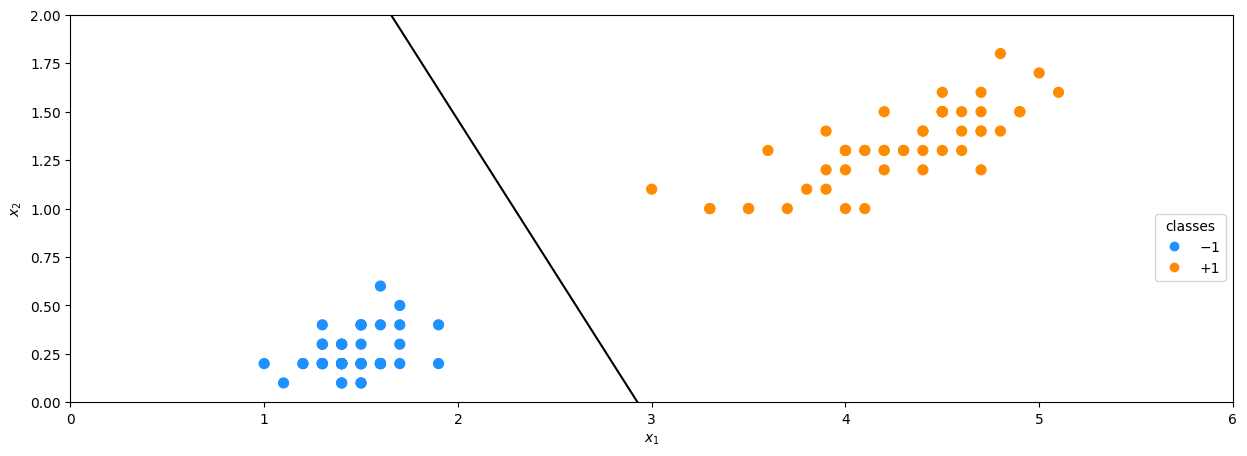

In [46]:
def hard_margin_svm(ax):
    x_space = np.linspace(0, ax.get_xlim(), 30)
    yc_best=-w_0/w_1*x_space-b/w_1
    plt.plot(x_space, yc_best, color='black', alpha=1, linestyle='-')

plot_svm(X, y, hard_margin_svm)

### Soft-Margin
We switch to another subset of the data, this time creating a non-separable dataset.

In [47]:
df=iris[(iris['species']!='setosa')]

df=df.drop(['sepal_length','sepal_width'], axis=1)

df=df.replace('virginica', 1)
df=df.replace('versicolor', -1)
df["species"] = pd.to_numeric(df["species"])

df=df.drop_duplicates()
df=df.drop(126) # this item creates contradictory data and thus an additional support vector. Just comment this line and see below

X=df.iloc[:,0:2]
y=df['species']

df.head()

,petal_length,petal_width,species
50,4.7,1.4,-1
51,4.5,1.5,-1
52,4.9,1.5,-1
53,4.0,1.3,-1
54,4.6,1.5,-1


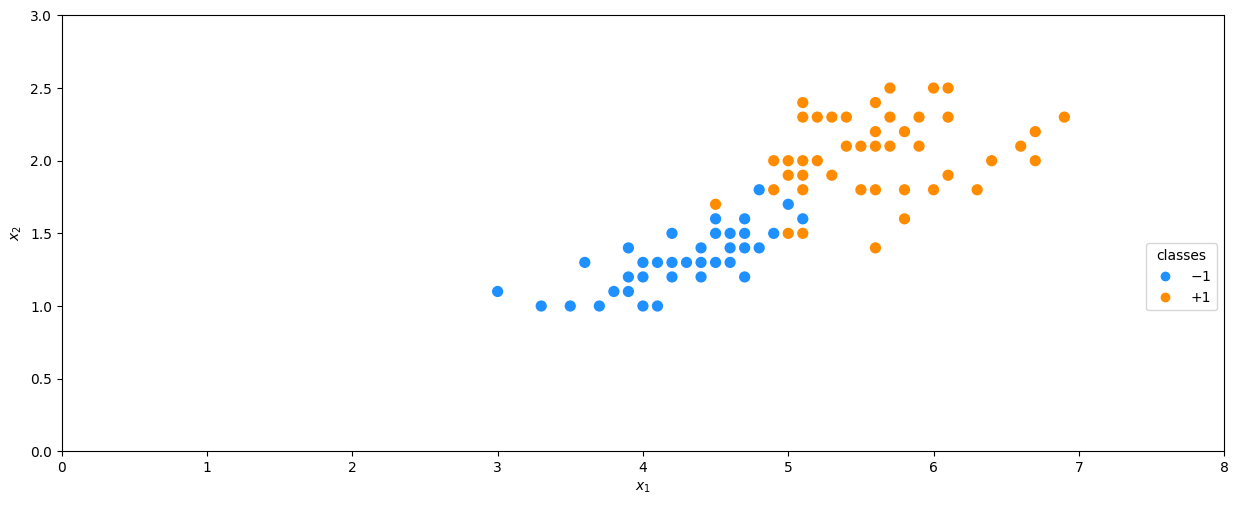

In [48]:
def no_content(ax):
    pass
plot_svm(X, y, no_content)

Let's try the same SVM for this dataset

In [49]:
model1 = SVC(kernel='linear', C=1E2)
model1.fit(X, y)
describe_svm(model1, X, y, "C", 1E2)

C:  100.0    svs:  11    train-acc:  0.925


In [50]:
w1=model1.coef_[0]
w1_0=w1[0]
w1_1=w1[1]
b1=model1.intercept_[0]
w1_0, w1_1, b1

(3.0776780612079784, 3.844764829506548, -21.61710863479213)

In [51]:
model2 = SVC(kernel='linear', C=1E-1)  # for soft-margin
model2.fit(X, y)
describe_svm(model2, X, y, "C", 1E-1)

C:  0.1    svs:  40    train-acc:  0.9375


In [52]:
w2=model2.coef_[0]
w2_0=w2[0]
w2_1=w2[1]
b2=model2.intercept_[0]
w2_0, w2_1, b2

(1.1100000000000012, 0.8700000000000001, -6.856999683380126)

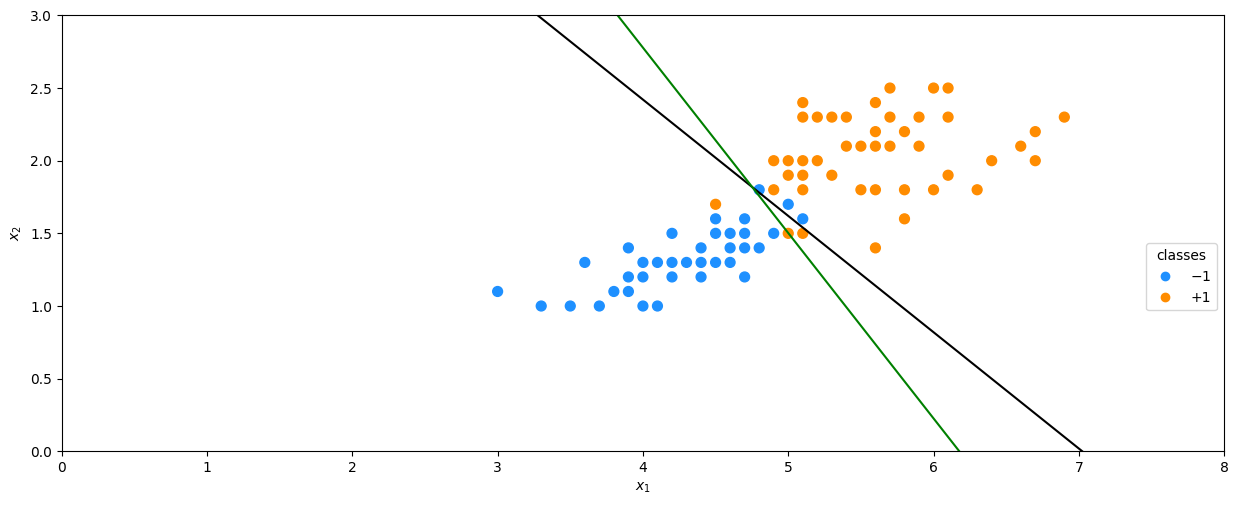

In [53]:
def two_svms(ax):
    x_space = np.linspace(0, ax.get_xlim(), 30)
    yc1=-w1_0/w1_1*x_space-b1/w1_1
    yc2=-w2_0/w2_1*x_space-b2/w2_1

    plt.plot(x_space, yc1, color='black', alpha=1, linestyle='-')
    plt.plot(x_space, yc2, color='green', alpha=1, linestyle='-')

plot_svm(X, y, two_svms)

### Finding a good C

In [54]:
Cs = (0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,2,10,20,100,200)
support_vectors=[]
margin=[]
train_accs=[]

for C in Cs:
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)
    
    support_vectors.append(len(clf.support_vectors_))

    w=clf.coef_[0]
    np.dot(w,w)
    margin.append(np.dot(w, w)**(-.5))

    y_pred=clf.predict(X)
    train_accs.append(round(metrics.accuracy_score(y, y_pred),5))


Text(0, 0.5, 'train-acc')

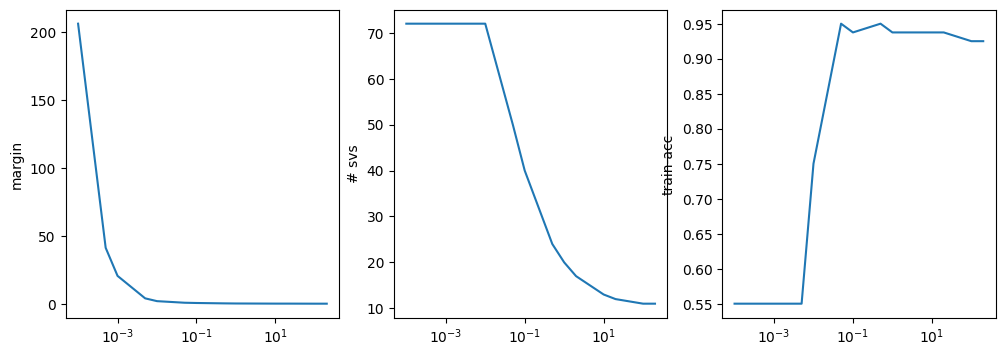

In [55]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].set_xscale('log')
ax[0].plot(Cs, margin)
ax[0].set_ylabel('margin')
ax[1].set_xscale('log')
ax[1].plot(Cs, support_vectors)
ax[1].set_ylabel('# svs')
ax[2].set_xscale('log')
ax[2].plot(Cs, train_accs) 
ax[2].set_ylabel('train-acc')

* C low -> focus on margin, allow a lot of digressions -> many svs, low training-acc 
* C high -> better fit to the training data, less digressions, but also smaller margin -> __needs to be tested using previously unseen test data!__

### Kernel Tricks
Now we investigate the use of kernels.

In [56]:
from classification_viz import plot_decisions_2d
import matplotlib.pyplot as plt

def evaluate_svm(clf, X, y, param_name, param):
    describe_svm(clf, X, y, param_name, param)
    plot_decisions_2d(X, y, clf)    
    plt.show()  

#### Polynomial Kernel

degree:  1    svs:  17    train-acc:  0.9375


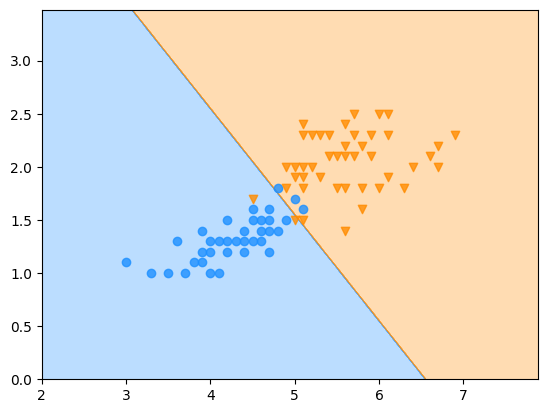

degree:  2    svs:  11    train-acc:  0.925


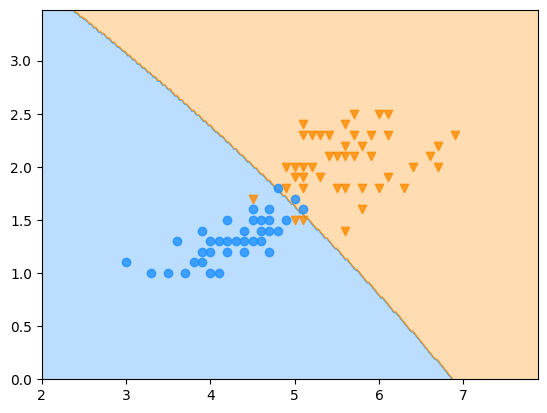

degree:  3    svs:  11    train-acc:  0.95


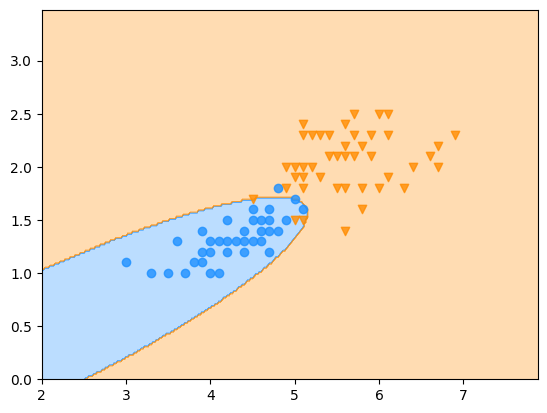

degree:  4    svs:  10    train-acc:  0.975


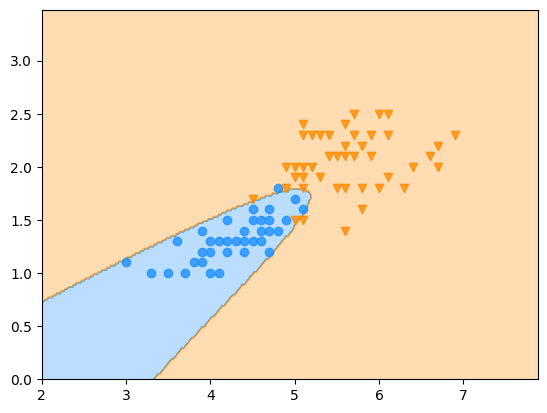

degree:  5    svs:  10    train-acc:  0.9625


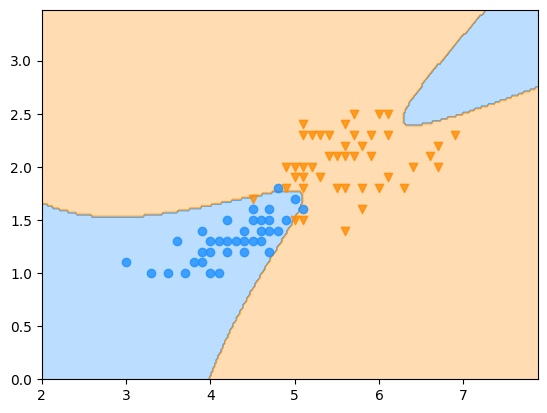

In [57]:
for degree in (1, 2, 3, 4, 5):
    clf = SVC(kernel='poly', degree=degree, gamma=2, coef0=1, C=1, tol=1E-5)
    evaluate_svm(clf, X.values, y, param_name="degree", param=degree)

#### Radial Basis Function Kernel

gamma:  0.01    svs:  66    train-acc:  0.9375


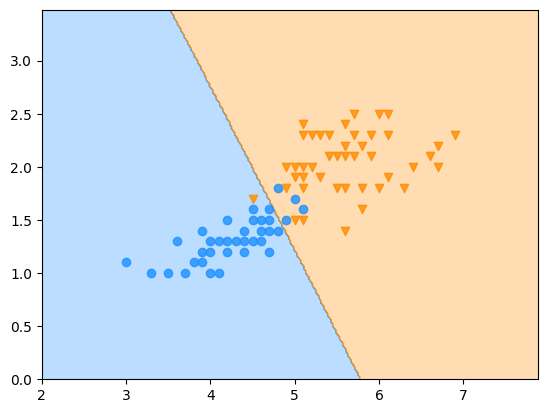

gamma:  0.1    svs:  33    train-acc:  0.95


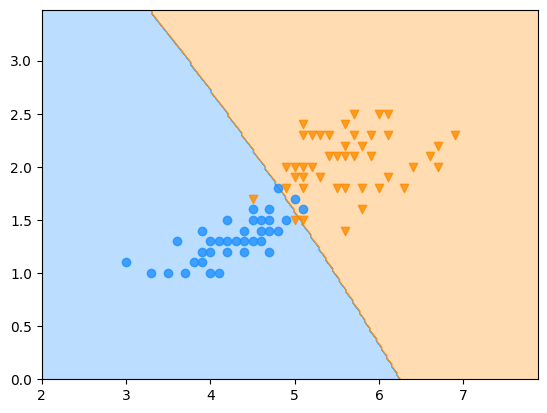

gamma:  0.5    svs:  23    train-acc:  0.95


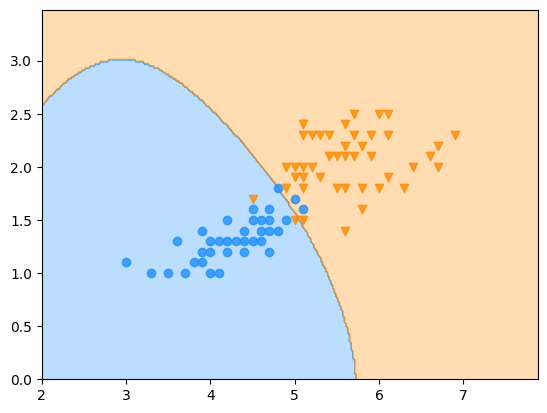

gamma:  1    svs:  20    train-acc:  0.9375


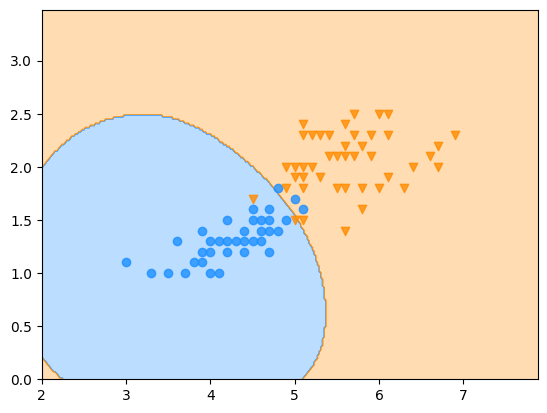

gamma:  10    svs:  41    train-acc:  0.95


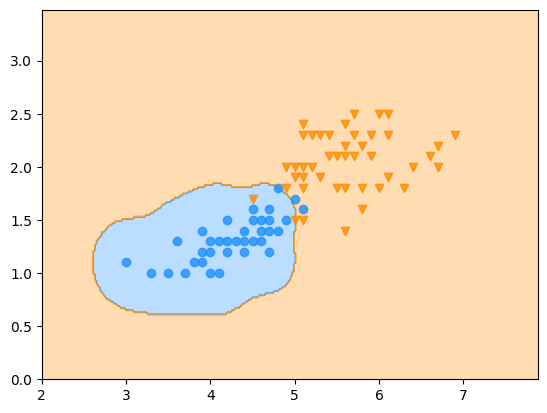

gamma:  100    svs:  79    train-acc:  1.0


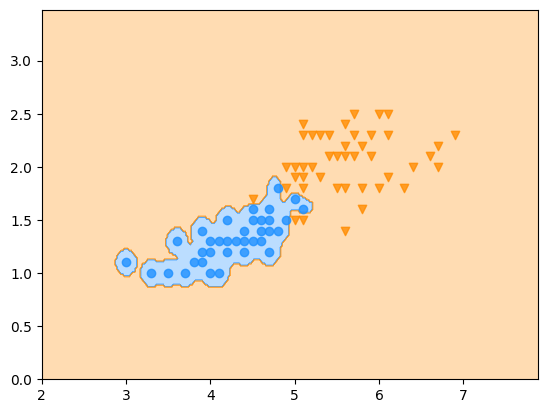

gamma:  1000    svs:  80    train-acc:  1.0


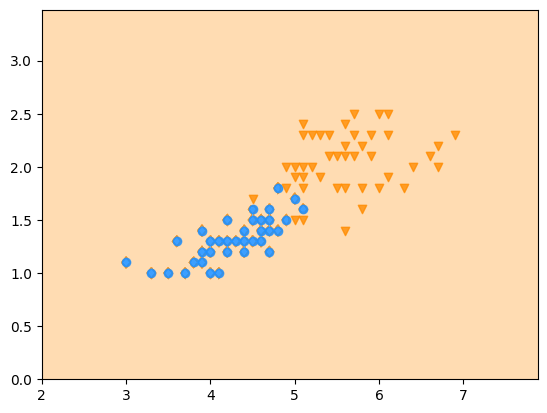

In [58]:
for gamma in (0.01, 0.1, 0.5, 1, 10, 100, 1000):
    clf = SVC(kernel='rbf', gamma=gamma, C=1, tol=1E-5)
    evaluate_svm(clf, X.values, y, param_name="gamma", param=gamma)

<div class="alert alert-block alert-info">
<b>Take Aways:</b> 

* SVMs for binary classification.
* SVMs with (almost) hard and soft margin
* The Kernel Trick
</div>

<div class="alert alert-block alert-success">
<b>Play with:</b> 
    
* Use the digits dataset (from our walkthrough in the beginning)
* Conduct similar experiments and observe the results of different kernels.
</div>